In [2]:
#%%
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import typing as T
import re
import numpy as np
from dataclasses import dataclass

from shared import bootstrap_accuracy, bootstrap_auc, dataset_local_path, simple_boxplot

In [3]:
RAND = 123456
random.seed(RAND)

# Using 'pandas' to load data now:
df: pd.DataFrame = pd.read_json(
    dataset_local_path("lit-wiki-2020.jsonl.gz"), lines=True
)

In [4]:
df

,wiki_id,truth_value,title,labels,body,names,page_rank
0,enwiki:WTYB,False,WTYB,[modern],WTYB (103.9 FM) is a radio station licensed to...,WTYB\tWTYB-FM,2.147576e-08
1,enwiki:Dave%20Taylor%20(wrestler),False,Dave Taylor (wrestler),[modern],David Taylor (born 1 May 1957) is a retired En...,Squire (disambiguation)\tDave Taylor\tDavid Ta...,1.127478e-07
2,enwiki:M%C3%A4gari,True,Mägari,[maybe-literary],"Mägari is a village in Ridala Parish, Lääne Co...",Mägari,2.147576e-08
3,enwiki:Owen%20Oglethorp,False,Owen Oglethorp,[disambiguation or weird wiki page],Owen Oglethorp may refer to:,"Owen Oglethorp (disambiguation)\tOglethorp, Ow...",2.147576e-08
4,enwiki:Dailekh%20District,False,Dailekh District,[technical],Dailekh District (;) a part of Karnali Prades...,Dailekh District\tDailekh\tDailekh district\tD...,2.147576e-08
...,...,...,...,...,...,...,...
1899,enwiki:KAHR,False,KAHR,[modern],KAHR (96.7 FM) is a radio station broadcasting...,KAHR,2.147576e-08
1900,enwiki:Canadian%20Nuclear%20Association,False,Canadian Nuclear Association,[modern],"The Canadian Nuclear Association (CNA), founde...",CNA\tCanadian Nuclear Association\tCanadian,2.147576e-08
1901,enwiki:15th%20Wing%20(disambiguation),False,15th Wing (disambiguation),[disambiguation],The 15th Wing is a wing of the United States A...,15th Wing (disambiguation),2.147576e-08
1902,enwiki:Crni%20Kao%20(Ra%C5%BEanj),True,Crni Kao (Ražanj),[specific-place],Crni Kao is a village in the municipality of R...,Crni Kao (Ražanj)\tCrni Kao\tCrni Kao (Razanj),3.973016e-08


In [5]:
# Regular expresssions to grab parts of the text:
WORDS = re.compile(r"(\w+)")
NUMBERS = re.compile(r"(\d+)")


def extract_features(row):
    """
    Given the title and body of a Wikipedia article,
    extract features that might be of use to the 'is literary' task.

    Return named features in a dictionary.
    """
    title = row["title"].lower()
    body = row["body"]

    new_features: T.Dict[str, T.Any] = {}
    words = WORDS.findall(body)
    numbers = [int(x) for x in NUMBERS.findall(body)]

    new_features = {
        "disambig": "disambiguation" in title,
        "page_rank": row["page_rank"],
        "length": len(words),
        "18xx": sum(1 for x in numbers if 1800 < x <= 1900),
        'lit':'literary' in title,
        'book':('book' in title) | ('book' in body)
#         "random2": random.random(),
#         "random3": random.random(),
#         "random4": random.random()
    }
    if len(numbers) > 0:
        new_features["mean_n"] = np.mean(numbers)
        new_features["std_n"] = np.std(numbers)

    return new_features


# right now each entry of the dataframe is a dictionary; json_normalize flattenst hat for us.
designed_f = pd.json_normalize(df.apply(extract_features, axis="columns"))

In [6]:
#%%

# Pandas lets us join really easily.
features: pd.DataFrame = designed_f.join([df.truth_value])
# It also lets us get rid of missing values really easily, too.
features = features.fillna(0.0)

In [7]:
features

,disambig,page_rank,length,18xx,lit,book,mean_n,std_n,truth_value
0,False,2.147576e-08,231,0,False,False,981.782609,974.073471,False
1,False,1.127478e-07,1339,0,False,False,1258.791045,956.898247,False
2,False,2.147576e-08,17,0,False,False,0.000000,0.000000,True
3,False,2.147576e-08,5,0,False,False,0.000000,0.000000,False
4,False,2.147576e-08,447,0,False,False,316.352941,591.831515,False
...,...,...,...,...,...,...,...,...,...
1899,False,2.147576e-08,68,0,False,False,871.285714,965.453071,False
1900,False,2.147576e-08,135,0,False,False,1340.000000,876.812409,False
1901,True,2.147576e-08,18,0,False,False,15.000000,0.000000,False
1902,False,3.973016e-08,30,0,False,False,1253.000000,749.000000,True


In [56]:
#%%
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

# split the whole dataframe (including y-values)
tv_f, test_f = train_test_split(features, test_size=0.25, random_state=RAND)
train_f, vali_f = train_test_split(tv_f, test_size=0.25, random_state=RAND)

# feature numberer
numberer = DictVectorizer(sparse=False)
# feature scaling
scaling = StandardScaler()


def prepare_data(
    df: pd.DataFrame, fit: bool = False
) -> T.Tuple[np.ndarray, np.ndarray]:
    """ This function converts a dataframe to an (X, y) tuple. It learns if fit=True."""
    global numeric, scaling
    y = df.pop("truth_value").values
    # use fit_transform only on training data:
    if fit:
        return y, scaling.fit_transform(numberer.fit_transform(df.to_dict("records")))
    # use transform on vali & test:
    return y, scaling.transform(
        numberer.transform(df.to_dict("records"))
    )  # type:ignore


# use the 'prepare_data' function right above here:
train_y, train_X = prepare_data(train_f, fit=True)
vali_y, vali_X = prepare_data(vali_f)
test_y, test_X = prepare_data(test_f)

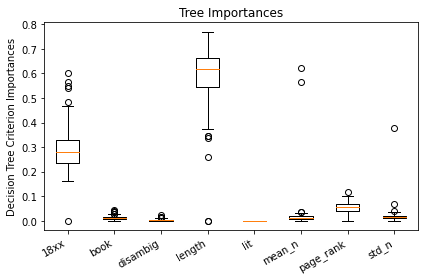

<module 'matplotlib.pyplot' from '/Users/Alderik/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [57]:
#%%
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Direct feature-importances (can think of them as how many times a feature was used):
rf = RandomForestClassifier(random_state=RAND, n_estimators=100)
rf.fit(train_X, train_y)

# loop over each tree and ask them how important each feature was!
importances = dict((name, []) for name in numberer.feature_names_)
for tree in rf.estimators_:
    for name, weight in zip(numberer.feature_names_, tree.feature_importances_):
        importances[name].append(weight)

# Think: what does 'how many splits' actually measure? Usefulness, or something else?
simple_boxplot(
    importances,
    title="Tree Importances",
    ylabel="Decision Tree Criterion Importances",
    save="graphs/p10-tree-importances.png",
)

In [58]:
#%%

graphs: T.Dict[str, T.List[float]] = {}


@dataclass
class Model:
    vali_score: float
    m: T.Any


def train_and_eval(name, x, y, vx, vy):
    """ Train and Eval a single model. """
    options: T.List[Model] = []
    for i in range(5):
        m = SGDClassifier(class_weight="balanced", random_state=RAND + i)
        m.fit(x, y)
        options.append(Model(m.score(vx, vy), m))

    for d in range(3, 15):
        m = DecisionTreeClassifier(
            max_depth=d, class_weight="balanced", random_state=RAND
        )
        m.fit(x, y)
        options.append(Model(m.score(vx, vy), m))

    # pick the best model:
    best = max(options, key=lambda m: m.vali_score)
    # bootstrap its output:
    graphs[name] = bootstrap_accuracy(best.m, vx, vy)
    # record our progress:
    print("{:20}\t{:.3}\t{}".format(name, np.mean(graphs[name]), best.m))


train_and_eval("Full Model", train_X, train_y, vali_X, vali_y)

for fid, fname in enumerate(numberer.feature_names_):
    # one-by-one, delete your features:
    without_X = train_X.copy()
    without_X[:, fid] = 0.0
    # score a model without the feature to see if it __really__ helps or not:
    train_and_eval("without {}".format(fname), without_X, train_y, vali_X, vali_y)

Full Model          	0.738	SGDClassifier(class_weight='balanced', random_state=123457)
without 18xx        	0.652	SGDClassifier(class_weight='balanced', random_state=123458)
without book        	0.744	SGDClassifier(class_weight='balanced', random_state=123458)
without disambig    	0.738	SGDClassifier(class_weight='balanced', random_state=123457)
without length      	0.742	DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       random_state=123456)
without lit         	0.738	SGDClassifier(class_weight='balanced', random_state=123457)
without mean_n      	0.745	SGDClassifier(class_weight='balanced', random_state=123459)
without page_rank   	0.747	SGDClassifier(class_weight='balanced', random_state=123457)
without std_n       	0.741	SGDClassifier(class_weight='balanced', random_state=123459)


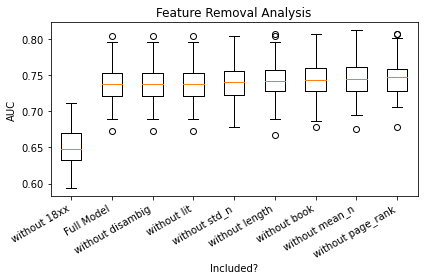

In [59]:
# Inline boxplot code here so we can sort by value:
box_names = []
box_dists = []
for (k, v) in sorted(graphs.items(), key=lambda tup: np.mean(tup[1])):
    box_names.append(k)
    box_dists.append(v)

# Matplotlib stuff:
plt.boxplot(box_dists)
plt.xticks(
    rotation=30,
    horizontalalignment="right",
    ticks=range(1, len(box_names) + 1),
    labels=box_names,
)
plt.title("Feature Removal Analysis")
plt.xlabel("Included?")
plt.ylabel("AUC")
plt.tight_layout()
plt.savefig("graphs/p10-feature-removal.png")
plt.show()

# TODO: Try to engineer some features!

### 1. Remove __obviously__ evil features (random1,random2,random3,random4)

done

### 2. Add some good features
##### 2.1. See commented-out 18xx feature for ideas on how to use 'numbers'
##### 2.2. 'List_of_...' pages aren't considered literary

Added lit and book features

improved from .63 best model AUC -> .74 best model AUC

### 3. Remove bad features (that weren't as obvious!)
### ... could adding a random feature help you here?

### (optional). Consider improving ``train_and_eval`` to use more powerful models

random showed that the lit feature I added does nothing, so I would remove that. 